# End-to-End AutoML for Insurance Cross-Sell

## Part 3 - H2O AutoML with MLflow

### Contents
[Part 1 - Initial Setup](#setup)  
[Part 2 - H2O AutoML Training with MLflow Tracking](#automl)  
[Part 3 - Predict with H2O AutoML Best Model](#predict)  
[Part 4 - H2O Model Explainability](#explain)  
[Part 5 - References](#references)

___
<a name="setup"></a>
## (1) Initial Setup

### Install pre-requisite dependencies

In [1]:
# !pip install requests
# !pip install tabulate
# !pip install future

### Install H2O in Python

In [2]:
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

### Install MLflow

In [3]:
# !pip install mlflow

### Import dependencies and datasets

In [4]:
# Import libraries
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

import pandas as pd
import json

from sklearn.metrics import f1_score, accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

### Initiate H2O cluster

In [5]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8); OpenJDK 64-Bit Server VM (build 11.0.13+8, mixed mode)
  Starting server from /home/amin/.local/share/virtualenvs/e2e-insurance-cross-sell-prediction-automl-eEZ4gcUa/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1mc4xd5k
  JVM stdout: /tmp/tmp1mc4xd5k/h2o_amin_started_from_python.out
  JVM stderr: /tmp/tmp1mc4xd5k/h2o_amin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Africa/Tunis
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,3 months and 14 days !!!
H2O_cluster_name:,H2O_from_python_amin_tvm89v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.910 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Setup MLflow

- First open Powershell terminal and change path to the directory hosting this notebook
- Enter `mlflow ui` to initiate MLFlow server
- Once done, access the MLFlow UI served on http://127.0.0.1:5000

In [6]:
# Initialize MLFlow client
client = MlflowClient()

# Set up MlFlow experiment
experiment_name = 'automl-insurance'

try:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = client.get_experiment_by_name(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    
mlflow.set_experiment(experiment_name)

# Print experiment details
print(f"Name: {experiment_name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Tracking uri: {mlflow.get_tracking_uri()}")

Name: automl-insurance
Experiment_id: 1
Artifact Location: file:///home/amin/Documents/e2e-insurance-cross-sell-prediction-automl/mlruns/1
Tags: {}
Lifecycle_stage: active
Tracking uri: file:///home/amin/Documents/e2e-insurance-cross-sell-prediction-automl/mlruns


___
<a name="automl"></a>
## (2) H2O AutoML Training with MLFlow Tracking

### Import training data
- Not splitting further into train/val set because 5-fold cross-val is applied by default in the AutoML training

In [7]:
# Import data directly as H2O frame
main_frame = h2o.import_file(path='data/processed/train.csv')

# Save data types of columns in H2O frame (for matching with test set during prediction)
with open('data/processed/train_col_types.json', 'w') as fp:
    json.dump(main_frame.types, fp)

# Alternatively, can first import as pandas csv, then convert to H2O frame
# main_df = pd.read_csv('data/processed/train.csv')
# main_frame = h2o.H2OFrame(main_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
# Set predictor and target columns
target = 'Response'
predictors = [n for n in main_frame.col_names if n != target]

# Factorize target variable so that autoML tackles classification problem (instead of regression)
main_frame[target] = main_frame[target].asfactor()

# Visualize H2O frame structure
main_frame.head()

Gender,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Region_Code_1,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Region_Code_19,Region_Code_2,Region_Code_20,Region_Code_21,Region_Code_22,Region_Code_23,Region_Code_24,Region_Code_25,Region_Code_26,Region_Code_27,Region_Code_28,Region_Code_29,Region_Code_3,Region_Code_30,Region_Code_31,Region_Code_32,Region_Code_33,Region_Code_34,Region_Code_35,Region_Code_36,Region_Code_37,Region_Code_38,Region_Code_39,Region_Code_4,Region_Code_40,Region_Code_41,Region_Code_42,Region_Code_43,Region_Code_44,Region_Code_45,Region_Code_46,Region_Code_47,Region_Code_48,Region_Code_49,Region_Code_5,Region_Code_50,Region_Code_51,Region_Code_52,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Vehicle_Age_lt_1Y,Vehicle_Age_gt_2Y,Vehicle_Damage_Yes,Policy_Sales_Channel_10,Policy_Sales_Channel_100,Policy_Sales_Channel_101,Policy_Sales_Channel_102,Policy_Sales_Channel_103,Policy_Sales_Channel_104,Policy_Sales_Channel_105,Policy_Sales_Channel_106,Policy_Sales_Channel_107,Policy_Sales_Channel_108,Policy_Sales_Channel_109,Policy_Sales_Channel_11,Policy_Sales_Channel_110,Policy_Sales_Channel_111,Policy_Sales_Channel_113,Policy_Sales_Channel_114,Policy_Sales_Channel_115,Policy_Sales_Channel_116,Policy_Sales_Channel_117,Policy_Sales_Channel_118,Policy_Sales_Channel_119,Policy_Sales_Channel_12,Policy_Sales_Channel_120,Policy_Sales_Channel_121,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_125,Policy_Sales_Channel_127,Policy_Sales_Channel_128,Policy_Sales_Channel_129,Policy_Sales_Channel_13,Policy_Sales_Channel_130,Policy_Sales_Channel_131,Policy_Sales_Channel_132,Policy_Sales_Channel_133,Policy_Sales_Channel_134,Policy_Sales_Channel_135,Policy_Sales_Channel_136,Policy_Sales_Channel_137,Policy_Sales_Channel_138,Policy_Sales_Channel_139,Policy_Sales_Channel_14,Policy_Sales_Channel_140,Policy_Sales_Channel_143,Policy_Sales_Channel_145,Policy_Sales_Channel_146,Policy_Sales_Channel_147,Policy_Sales_Channel_148,Policy_Sales_Channel_149,Policy_Sales_Channel_15,Policy_Sales_Channel_150,Policy_Sales_Channel_151,Policy_Sales_Channel_152,Policy_Sales_Channel_153,Policy_Sales_Channel_154,Policy_Sales_Channel_155,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_158,Policy_Sales_Channel_159,Policy_Sales_Channel_16,Policy_Sales_Channel_160,Policy_Sales_Channel_163,Policy_Sales_Channel_17,Policy_Sales_Channel_18,Policy_Sales_Channel_19,Policy_Sales_Channel_2,Policy_Sales_Channel_20,Policy_Sales_Channel_21,Policy_Sales_Channel_22,Policy_Sales_Channel_23,Policy_Sales_Channel_24,Policy_Sales_Channel_25,Policy_Sales_Channel_26,Policy_Sales_Channel_27,Policy_Sales_Channel_28,Policy_Sales_Channel_29,Policy_Sales_Channel_3,Policy_Sales_Channel_30,Policy_Sales_Channel_31,Policy_Sales_Channel_32,Policy_Sales_Channel_34,Policy_Sales_Channel_35,Policy_Sales_Channel_36,Policy_Sales_Channel_37,Policy_Sales_Channel_38,Policy_Sales_Channel_39,Policy_Sales_Channel_4,Policy_Sales_Channel_40,Policy_Sales_Channel_41,Policy_Sales_Channel_42,Policy_Sales_Channel_44,Policy_Sales_Channel_45,Policy_Sales_Channel_46,Policy_Sales_Channel_47,Policy_Sales_Channel_48,Policy_Sales_Channel_49,Policy_Sales_Channel_51,Policy_Sales_Channel_52,Policy_Sales_Channel_53,Policy_Sales_Channel_54,Policy_Sales_Channel_55,Policy_Sales_Channel_56,Policy_Sales_Channel_57,Policy_Sales_Channel_58,Policy_Sales_Channel_59,Policy_Sales_Channel_6,Policy_Sales_Channel_60,Policy_Sales_Channel_61,Policy_Sales_Channel_62,Policy_Sales_Channel_63,Policy_Sales_Channel_64,Policy_Sales_Channel_65,Policy_Sales_Channel_66,Policy_Sales_Channel_67,Policy_Sales_Channel_68,Policy_Sales_Channel_69,Policy_Sales_Channel_7,Policy_Sales_Channel_70,Policy_Sales_Channel_71,Policy_Sales_Channel_73,Policy_Sales_Channel_74,Policy_Sales_Channel_75,Policy_Sales_Channel_76,Policy_Sales_Channel_78,Policy_Sales_Channel_79,Policy_Sales_Channel_

### Start H2O AutoML training with MLflow tracking

In [9]:
# Wrap autoML training with MLflow
with mlflow.start_run():
    aml = H2OAutoML(
                    max_models=13, # Run AutoML for n base models
                    seed=42, 
                    balance_classes=True, # Our target classes are imbalanced, so we set this to True
                    sort_metric='logloss', # Sort models by logloss (main metric for multi-classification)
                    verbosity='info', # Turn on verbose info
                    exclude_algos = ['GLM', 'DRF'], # Specify which algorithms to exclude
                   )
    
    aml.train(x=predictors, y=target, training_frame=main_frame)
    
    # Set metrics to log
    mlflow.log_metric("log_loss", aml.leader.logloss())
    mlflow.log_metric("AUC", aml.leader.auc())
    
    # Log best model (mlflow.h2o module provides API for logging & loading H2O models)
    mlflow.h2o.log_model(aml.leader, 
                         artifact_path="model"
                        )
    
    model_uri = mlflow.get_artifact_uri("model")
    print(model_uri)
    
    # Print and view AutoML Leaderboard
    lb = get_leaderboard(aml, extra_columns='ALL')
    print(lb.head(rows=lb.nrows))
    
    # Get IDs of current experiment run
    exp_id = experiment.experiment_id
    run_id = mlflow.active_run().info.run_id
    
    # Save leaderboard as CSV
    lb_path = f'mlruns/{exp_id}/{run_id}/artifacts/model/leaderboard.csv'
    lb.as_data_frame().to_csv(lb_path, index=False) 
    print(f'Leaderboard saved in {lb_path}')

AutoML progress: |
16:35:21.159: Project: AutoML_1_20220121_163521
16:35:21.165: Setting stopping tolerance adaptively based on the training frame: 0.0033065124063248246
16:35:21.166: Build control seed: 42
16:35:21.166: training frame: Frame key: AutoML_1_20220121_163521_training_py_1_sid_8f18    cols: 208    rows: 91466  chunks: 32    size: 2498353  checksum: -277864416819399133
16:35:21.166: validation frame: NULL
16:35:21.167: leaderboard frame: NULL
16:35:21.167: blending frame: NULL
16:35:21.167: response column: Response
16:35:21.167: fold column: null
16:35:21.167: weights column: null
16:35:21.175: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]}, {DeepLearning : [def_1 (3g, 10w), grid_1 (4g, 30w

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_2_AutoML_1_20220121_163521,0.267693,0.857561,0.370057,0.237628,0.296148,0.0877036,2279,0.020652,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20220121_163521,0.267708,0.857512,0.370124,0.23828,0.296157,0.0877089,2556,0.025513,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20220121_163521,0.26778,0.857369,0.369595,0.239951,0.29621,0.0877403,1838,0.005853,StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20220121_163521,0.267796,0.857505,0.369818,0.229687,0.296192,0.0877297,22324,0.022587,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_1_20220121_163521,0.26787,0.857296,0.369078,0.23661,0.296256,0.0877674,18751,0.004722,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20220121_163521,0.268136,0.856936,0.370027,0.235645,0.296295,0.0877905,2218,0.00939,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20220121_163521,0.268228,0.856598,0.369316,0.234249,0.296381,0.0878418,1773,0.003572,StackedEnsemble
GBM_2_AutoML_1_20220121_163521,0.268615,0.856495,0.369483,0.226896,0.296556,0.0879456,8298,0.002441,GBM
XGBoost_3_AutoML_1_20220121_163521,0.268711,0.855771,0.364893,0.229421,0.296751,0.0880609,1514,0.001294,XGBoost
GBM_5_AutoML_1_20220121_163521,0.268782,0.856372,0.370302,0.231764,0.296605,0.0879743,6948,0.002437,GBM



Leaderboard saved in mlruns/1/6f2d4b47e37645b88a01aea5ba465e28/artifacts/model/leaderboard.csv


### View AutoML logs

In [10]:
# Get AutoML event log
log = aml.event_log
log

timestamp,level,stage,message,name,value
16:35:21.159,Info,Workflow,Project: AutoML_1_20220121_163521,,
16:35:21.165,Info,Validation,Setting stopping tolerance adaptively based on the training frame: 0.0033065124063248246,,
16:35:21.166,Info,Validation,Build control seed: 42,,
16:35:21.166,Info,DataImport,training frame: Frame key: AutoML_1_20220121_163521_training_py_1_sid_8f18 cols: 208 rows: 91466 chunks: 32 size: 2498353 checksum: -277864416819399133,,
16:35:21.166,Info,DataImport,validation frame: NULL,,
16:35:21.167,Info,DataImport,leaderboard frame: NULL,,
16:35:21.167,Info,DataImport,blending frame: NULL,,
16:35:21.167,Info,DataImport,response column: Response,,
16:35:21.167,Info,DataImport,fold column: null,,
16:35:21.167,Info,DataImport,weights column: null,,


### View best model

In [11]:
# Leader (best) model stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_1_20220121_163521

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08537758056294917
RMSE: 0.2921944225390847
LogLoss: 0.2587869355251726
Null degrees of freedom: 9974
Residual degrees of freedom: 9966
Null deviance: 7583.321730258964
Residual deviance: 5162.799363727194
AIC: 5180.799363727194
AUC: 0.876164866479019
AUCPR: 0.4475357523278229
Gini: 0.7523297329580381

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24313533374730487: 


,,0,1,Error,Rate
0,0,6792.0,1919.0,0.2203,(1919.0/8711.0)
1,1,222.0,1042.0,0.1756,(222.0/1264.0)
2,Total,7014.0,2961.0,0.2146,(2141.0/9975.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.243135,0.493254,195.0
1,max f2,0.138887,0.665671,280.0
2,max f0point5,0.351315,0.440540,96.0
3,max accuracy,0.421353,0.878797,38.0
4,max precision,0.584605,1.000000,0.0
5,max recall,0.015326,1.000000,377.0
6,max specificity,0.584605,1.000000,0.0
7,max absolute_mcc,0.240001,0.440294,198.0
8,max min_per_class_accuracy,0.256273,0.791930,184.0
9,max mean_per_class_accuracy,0.138887,0.816474,280.0



Gains/Lift Table: Avg response rate: 12.67 %, avg score: 13.03 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,0.442034,5.603046,5.603046,0.710000,0.468182,0.710000,0.468182,0.056171,0.056171,460.304589,460.304589,0.052842
1,2,0.020050,0.421141,4.419304,5.011175,0.560000,0.429921,0.635000,0.449052,0.044304,0.100475,341.930380,401.117484,0.092094
2,3,0.030075,0.408114,3.314478,4.445609,0.420000,0.414990,0.563333,0.437698,0.033228,0.133703,231.447785,344.560918,0.118664
3,4,0.040000,0.397592,3.666811,4.252373,0.464646,0.402418,0.538847,0.428944,0.036392,0.170095,266.681051,325.237342,0.148972
4,5,0.050025,0.391139,3.077729,4.016974,0.390000,0.394060,0.509018,0.421953,0.030854,0.200949,207.772943,301.697382,0.172824
5,6,0.100050,0.361629,3.083897,3.550436,0.390782,0.376552,0.449900,0.399253,0.154272,0.355222,208.389722,255.043552,0.292198
6,7,0.150075,0.333060,2.815045,3.305305,0.356713,0.347117,0.418838,0.381874,0.140823,0.496044,181.504465,230.530523,0.396171
7,8,0.200000,0.309387,2.408685,3.081487,0.305221,0.321366,0.390476,0.366770,0.120253,0.616297,140.868537,208.148734,0.476704
8,9,0.300050,0.239757,2.135006,2.765888,0.270541,0.278391,0.350484,0.337300,0.213608,0.829905,113.500577,176.588807,0.606739
9,10,0.400000,0.137013,1.218965,2.379351,0.154463,0.188820,0.301504,0.300199,0.121835,0.951741,21.896544,137.935127,0.631800




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08770362334242507
RMSE: 0.2961479754150365
LogLoss: 0.26769269449672595
Null degrees of freedom: 91465
Residual degrees of freedom: 91457
Null deviance: 68811.90506765014
Residual deviance: 48969.55998967507
AIC: 48987.55998967507
AUC: 0.8575608446815696
AUCPR: 0.3700568332452403
Gini: 0.7151216893631391

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25114266443266603: 


,,0,1,Error,Rate
0,0,63881.0,16181.0,0.2021,(16181.0/80062.0)
1,1,3115.0,8289.0,0.2731,(3115.0/11404.0)
2,Total,66996.0,24470.0,0.211,(19296.0/91466.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.251143,0.462117,187.0
1,max f2,0.124363,0.642087,288.0
2,max f0point5,0.312132,0.395582,131.0
3,max accuracy,0.518872,0.875396,5.0
4,max precision,0.565370,1.000000,0.0
5,max recall,0.000439,1.000000,399.0
6,max specificity,0.565370,1.000000,0.0
7,max absolute_mcc,0.144915,0.406708,272.0
8,max min_per_class_accuracy,0.226797,0.773325,207.0
9,max mean_per_class_accuracy,0.124363,0.800319,288.0



Gains/Lift Table: Avg response rate: 12.47 %, avg score: 12.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.434211,3.453644,3.453644,0.430601,0.458590,0.430601,0.458590,0.034549,0.034549,245.364430,245.364430,0.028042
1,2,0.020007,0.414185,3.646487,3.550066,0.454645,0.423167,0.442623,0.440878,0.036478,0.071028,264.648738,255.006584,0.058288
2,3,0.030000,0.401793,3.325795,3.475363,0.414661,0.407662,0.433309,0.429814,0.033234,0.104262,232.579513,247.536342,0.084839
3,4,0.040004,0.391726,3.339692,3.441436,0.416393,0.396498,0.429079,0.421483,0.033409,0.137671,233.969157,244.143619,0.111579
4,5,0.050008,0.384244,3.111786,3.375492,0.387978,0.387868,0.420857,0.414759,0.031129,0.168800,211.178611,237.549176,0.135714
5,6,0.100004,0.353987,3.121916,3.248718,0.389241,0.369155,0.405051,0.391960,0.156086,0.324886,212.191647,224.871798,0.256914
6,7,0.150001,0.325117,2.657137,3.051539,0.331292,0.339150,0.380466,0.374358,0.132848,0.457734,165.713677,205.153861,0.351566
7,8,0.200009,0.299131,2.474192,2.907186,0.308483,0.312427,0.362469,0.358873,0.123729,0.581463,147.419162,190.718609,0.435788
8,9,0.300002,0.221014,2.031000,2.615145,0.253225,0.263340,0.326057,0.327031,0.203087,0.784549,103.099959,161.514521,0.553566
9,10,0.400007,0.126414,1.403832,2.312309,0.175030,0.173419,0.288299,0.288627,0.140389,0.924939,40.383198,131.230862,0.599703


#### Learning Curve Plot

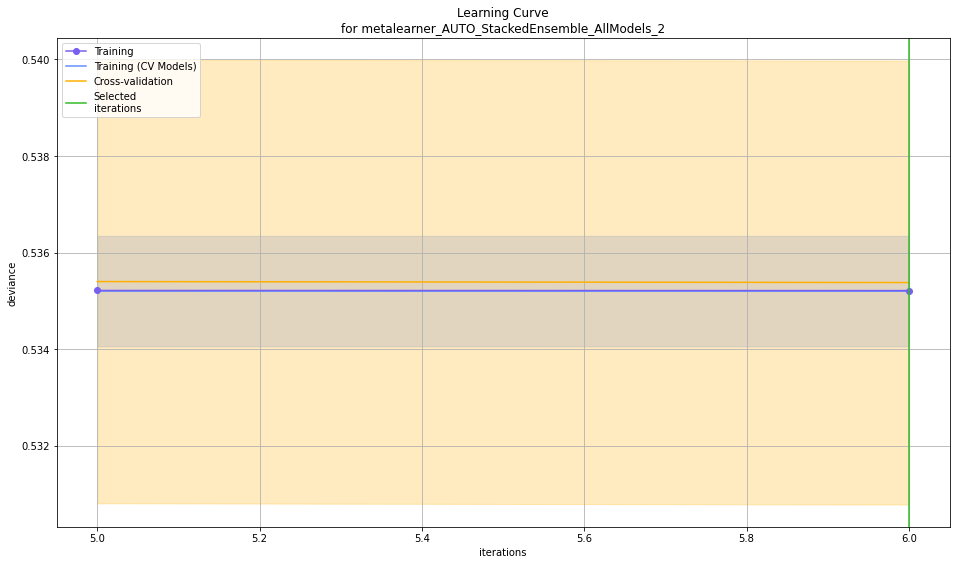

In [12]:
# Display learning curve
learning_curve_plot = aml.leader.learning_curve_plot()

___
<a name="predict"></a>
## (3) Predict with H2O AutoML Best Model

___
<a name="explain"></a>
## (4) H2O Model Explainability
- More info: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations